In [6]:
# audio libraries
import librosa
import librosa.display as lplt
import IPython

# import matplotlib to be able to display graphs
import matplotlib.pyplot as plt

# transform .wav into .csv
import csv
import os
import numpy as np
import pandas as pd

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# model
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
zip_path = '/content/drive/MyDrive/marine_sound_classification/archive.zip'

In [11]:
import zipfile
# Create a directory for extraction if it doesn't exist
extract_path = '/content/data'
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [12]:
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
/content/data/data/CommonDolphin/5702606V.wav
/content/data/data/CommonDolphin/5702601L.wav
/content/data/data/CommonDolphin/7500303Q.wav
/content/data/data/CommonDolphin/87003029.wav
/content/data/data/CommonDolphin/58014003.wav
/content/data/data/CommonDolphin/5801402G.wav
/content/data/data/CommonDolphin/57026032.wav
/content/data/data/CommonDolphin/5801402Y.wav
/content/data/data/CommonDolphin/7500305Q.wav
/content/data/data/CommonDolphin/6302100F.wav
/content/data/data/CommonDolphin/75003058.wav
/content/data/data/CommonDolphin/5702605T.wav
/content/data/data/CommonDolphin/8700300L.wav
/content/data/data/CommonDolphin/75003033.wav
/content/data/data/CommonDolphin/8700301F.wav
/content/data/data/CommonDolphin/5801401H.wav
/content/data/data/CommonDolphin/5702601T.wav
/content/data/data/CommonDolphin/8700301X.wav
/content/data/data/CommonDolphin/58013016.wav
/content/data/data/CommonDolphin/8700301R.wav
/content/data/data/CommonDolp

In [16]:
!pip install datasets

# Converting to Wave2Vec Embeddings and training

In [13]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, ClassLabel
import torch
import librosa
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directories and parameters
data_dir = "/content/data/data/"  # Replace with the path to your dataset
SAMPLE_RATE = 16000  # Wave2Vec2.0 expects 16 kHz audio

# Selected class folders to use
selected_classes = [
    "BowheadWhale",
    "Beluga_WhiteWhale",
    "SouthernRightWhale",
    "NorthernRightWhale",
    "Short_Finned(Pacific)PilotWhale",
    "Long_FinnedPilotWhale",
    "HumpbackWhale",
    "KillerWhale",
    "SpermWhale",
    "BottlenoseDolphin",
]  # Add or remove class folder names as needed

# Map class labels to IDs
LABELS = selected_classes  # Only selected classes
LABEL2ID = {label: idx for idx, label in enumerate(LABELS)}
ID2LABEL = {idx: label for label, idx in LABEL2ID.items()}

# Function to preprocess audio
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(audio) > SAMPLE_RATE:
        audio = audio[:SAMPLE_RATE]  # Trim to 1 second
    else:
        padding = SAMPLE_RATE - len(audio)
        audio = np.pad(audio, (0, padding))  # Pad if less than 1 second
    return audio

# Function to load dataset from selected class folders
def load_data(data_folder, selected_classes):
    audio_files = []
    labels = []
    for label in selected_classes:
        label_folder = os.path.join(data_folder, label)
        if os.path.exists(label_folder):
            for file_name in os.listdir(label_folder):
                file_path = os.path.join(label_folder, file_name)
                if file_path.lower().endswith((".wav", ".mp3")):  # Ensure only audio files
                    audio_files.append(file_path)
                    labels.append(LABEL2ID[label])
        else:
            print(f"Warning: Folder '{label}' does not exist in {data_folder}. Skipping...")
    return Dataset.from_dict({"audio": audio_files, "label": labels})

# Load dataset from all selected folders
full_dataset = load_data(data_dir, selected_classes)

# Convert labels to ClassLabel type
def convert_labels_to_classlabel(dataset, num_classes, labels):
    # Create a ClassLabel object
    class_label = ClassLabel(num_classes=num_classes, names=labels)

    # Apply the ClassLabel transformation
    dataset = dataset.cast_column("label", class_label)
    return dataset

# Convert the label column in the dataset
full_dataset = convert_labels_to_classlabel(
    full_dataset, num_classes=len(selected_classes), labels=selected_classes
)

# Now split the dataset
train_test_split = full_dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_data = train_test_split["train"]
val_data = train_test_split["test"]

# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({"audio": train_data["audio"], "label": train_data["label"]})
val_dataset = Dataset.from_dict({"audio": val_data["audio"], "label": val_data["label"]})

# Feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Preprocess dataset for Wav2Vec2.0
def preprocess(batch):
    audio = preprocess_audio(batch["audio"])
    inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values[0]
    return batch

train_dataset = train_dataset.map(preprocess, remove_columns=["audio"])
val_dataset = val_dataset.map(preprocess, remove_columns=["audio"])

# Convert to torch tensors
def to_torch(batch):
    batch["input_values"] = torch.tensor(batch["input_values"], dtype=torch.float32)
    batch["labels"] = torch.tensor(batch["label"], dtype=torch.long)
    return batch

train_dataset = train_dataset.map(to_torch)
val_dataset = val_dataset.map(to_torch)

# Prepare dataset for Hugging Face Trainer
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Load pre-trained Wav2Vec2.0 model for classification
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(LABELS),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Define the Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./marine_species_model_Wav2Vec")
feature_extractor.save_pretrained("./marine_species_model_Wav2Vec")


Casting the dataset:   0%|          | 0/7786 [00:00<?, ? examples/s]

Map:   0%|          | 0/6228 [00:00<?, ? examples/s]

Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

Map:   0%|          | 0/6228 [00:00<?, ? examples/s]

Map:   0%|          | 0/1558 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-b8f2def75fa5>:134: FutureWarning

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.710600,1.591131
2,1.771500,1.874290
3,1.795500,1.908717
4,1.795100,1.901207
5,1.964700,1.894819
6,1.977700,1.899363
7,1.697500,1.622429
8,1.691800,1.617493
9,1.787300,1.630196
10,1.816300,1.626929


['./marine_species_model_Wav2Vec/preprocessor_config.json']

# Further Evaluation

In [18]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00


In [19]:
from evaluate import load

# Load accuracy metric using evaluate
accuracy_metric = load("accuracy")

# Define custom metric function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Update Trainer with the new metric
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,  # Added accuracy computation
)

# Evaluate the model
eval_results = trainer.evaluate(eval_dataset=dataset["validation"])
test_loss = eval_results["eval_loss"]
test_accuracy = eval_results["eval_accuracy"]

print(f"The test loss is: {test_loss:.4f}")
print(f"The test accuracy is: {test_accuracy * 100:.2f}%")


<ipython-input-19-bd16c366cb91>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


The test loss is: 1.5911
The test accuracy is: 40.95%


# Training on the entire Dataset

In [26]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, ClassLabel
import torch
import librosa
import os
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# Directories and parameters
data_dir = "/content/data/data/"  # Replace with the path to your dataset
SAMPLE_RATE = 16000  # Wave2Vec2.0 expects 16 kHz audio

# Selected class folders to use
selected_classes = ['TucuxiDolphin',
 'NorthernRightWhale',
 'BowheadWhale',
 'Rough_ToothedDolphin',
 'PantropicalSpottedDolphin',
 'SpermWhale',
 'Beluga_WhiteWhale',
 "Dall'sPorpoise",
 'DuskyDolphin',
 'HarbourSeal',
 'BottlenoseDolphin',
 "Fraser'sDolphin",
 'FinlessPorpoise',
 'FalseKillerWhale',
 'SeaOtter',
 'StellerSeaLion',
 'SouthernRightWhale',
 'SpinnerDolphin',
 'WeddellSeal',
 'Fin_FinbackWhale',
 'GraySeal',
 'LongBeaked(Pacific)CommonDolphin',
 "Commerson'sDolphin",
 "Heaviside'sDolphin",
 'RibbonSeal',
 'ClymeneDolphin',
 'CommonDolphin',
 'NewZealandFurSeal',
 'LeopardSeal',
 'BeardedSeal',
 'HumpbackWhale',
 'JuanFernandezFurSeal',
 'WestIndianManatee',
 'KillerWhale',
 'IrawaddyDolphin',
 'HarborPorpoise',
 'StripedDolphin',
 'Walrus',
 'Narwhal',
 'GrayWhale',
 'Short_Finned(Pacific)PilotWhale',
 'SpottedSeal',
 'RingedSeal',
 'RossSeal',
 'White_beakedDolphin',
 'Long_FinnedPilotWhale',
 'AtlanticSpottedDolphin',
 'Boutu_AmazonRiverDolphin',
 'MinkeWhale',
 'HarpSeal',
 'HoodedSeal',
 'White_sidedDolphin',
 "Grampus_Risso'sDolphin",
 'BlueWhale',
 'MelonHeadedWhale']

# Map class labels to IDs
LABELS = selected_classes  # Only selected classes
LABEL2ID = {label: idx for idx, label in enumerate(LABELS)}
ID2LABEL = {idx: label for label, idx in LABEL2ID.items()}

# Function to preprocess audio
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(audio) > SAMPLE_RATE:
        audio = audio[:SAMPLE_RATE]  # Trim to 1 second
    else:
        padding = SAMPLE_RATE - len(audio)
        audio = np.pad(audio, (0, padding))  # Pad if less than 1 second
    return audio

# Function to load dataset from selected class folders
def load_data(data_folder, selected_classes):
    audio_files = []
    labels = []
    for label in selected_classes:
        label_folder = os.path.join(data_folder, label)
        if os.path.exists(label_folder):
            for file_name in os.listdir(label_folder):
                file_path = os.path.join(label_folder, file_name)
                if file_path.lower().endswith((".wav", ".mp3")):  # Ensure only audio files
                    audio_files.append(file_path)
                    labels.append(LABEL2ID[label])
        else:
            print(f"Warning: Folder '{label}' does not exist in {data_folder}. Skipping...")
    return Dataset.from_dict({"audio": audio_files, "label": labels})

# Load dataset from all selected folders
full_dataset = load_data(data_dir, selected_classes)



# Convert labels to ClassLabel type
def convert_labels_to_classlabel(dataset, num_classes, labels):
    # Create a ClassLabel object
    class_label = ClassLabel(num_classes=num_classes, names=labels)

    # Apply the ClassLabel transformation
    dataset = dataset.cast_column("label", class_label)
    return dataset

# Convert the label column in the dataset
full_dataset = convert_labels_to_classlabel(
    full_dataset, num_classes=len(selected_classes), labels=selected_classes
)

# Count occurrences of each label
label_counts = Counter(full_dataset['label'])

# Remove classes with fewer than 2 samples
sufficient_data_labels = [label for label, count in label_counts.items() if count >= 2]

# Filter the dataset
filtered_dataset = full_dataset.filter(lambda example: example['label'] in sufficient_data_labels)

# Now perform stratified split
train_test_split = filtered_dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_data = train_test_split["train"]
val_data = train_test_split["test"]

# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({"audio": train_data["audio"], "label": train_data["label"]})
val_dataset = Dataset.from_dict({"audio": val_data["audio"], "label": val_data["label"]})

# Feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Preprocess dataset for Wav2Vec2.0
def preprocess(batch):
    audio = preprocess_audio(batch["audio"])
    inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values[0]
    return batch

train_dataset = train_dataset.map(preprocess, remove_columns=["audio"])
val_dataset = val_dataset.map(preprocess, remove_columns=["audio"])

# Convert to torch tensors
def to_torch(batch):
    batch["input_values"] = torch.tensor(batch["input_values"], dtype=torch.float32)
    batch["labels"] = torch.tensor(batch["label"], dtype=torch.long)
    return batch

train_dataset = train_dataset.map(to_torch)
val_dataset = val_dataset.map(to_torch)

# Prepare dataset for Hugging Face Trainer
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Load pre-trained Wav2Vec2.0 model for classification
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(LABELS),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Load accuracy metric using evaluate
accuracy_metric = load("accuracy")

# Define custom metric function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Update Trainer with the new metric
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,  # Added accuracy computation
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./marine_species_model_Wav2Vec_allData")
feature_extractor.save_pretrained("./marine_species_model_Wav2Vec_allData")


Casting the dataset:   0%|          | 0/15567 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15567 [00:00<?, ? examples/s]

Map:   0%|          | 0/12452 [00:00<?, ? examples/s]

Map:   0%|          | 0/3113 [00:00<?, ? examples/s]

Map:   0%|          | 0/12452 [00:00<?, ? examples/s]

Map:   0%|          | 0/3113 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-c682a321e0e2>:198: FutureWarning

Epoch,Training Loss,Validation Loss,Accuracy
1,1.435600,1.564008,0.584003
2,1.013400,1.109632,0.731128
3,0.893500,1.074219,0.730164
4,0.684100,1.071425,0.749759


Epoch,Training Loss,Validation Loss,Accuracy
1,1.435600,1.564008,0.584003
2,1.013400,1.109632,0.731128
3,0.893500,1.074219,0.730164
4,0.684100,1.071425,0.749759
5,0.429100,1.024659,0.765500
6,0.330900,0.849322,0.821715
7,0.247000,0.825943,0.825249
8,0.859600,0.901575,0.815291
9,0.202700,0.900652,0.827819
10,0.102900,0.878602,0.834243


['./marine_species_model_Wav2Vec_allData/preprocessor_config.json']

In [27]:
# Load the trained model and feature extractor
model_path = "./marine_species_model_Wav2Vec_allData"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)

# Put model in evaluation mode
model.eval()


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [28]:
SAMPLE_RATE = 16000  # Ensure it matches the training sample rate

# Function to preprocess audio for prediction
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(audio) > SAMPLE_RATE:
        audio = audio[:SAMPLE_RATE]  # Trim to 1 second
    else:
        padding = SAMPLE_RATE - len(audio)
        audio = np.pad(audio, (0, padding))  # Pad if less than 1 second
    return audio

# Function to preprocess the test data
def preprocess_test_data(test_folder):
    audio_files = []
    file_paths = []
    for file_name in os.listdir(test_folder):
        file_path = os.path.join(test_folder, file_name)
        if file_path.lower().endswith(('.wav', '.mp3')):
            audio_files.append(preprocess_audio(file_path))
            file_paths.append(file_path)
    return audio_files, file_paths


# Predictions on unseen Data

In [30]:
# Provide the test directory path
test_data_dir = "/content/drive/MyDrive/marine_sound_classification/test_data"  # Change this to your test data path

# Load and preprocess test data
test_audios, test_file_paths = preprocess_test_data(test_data_dir)

# Prepare the test data for model input
inputs = feature_extractor(test_audios, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)


In [31]:
# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, axis=-1)

# Convert predictions to class labels
predicted_labels = [model.config.id2label[int(pred)] for pred in predictions]

# Display results
for file_path, label in zip(test_file_paths, predicted_labels):
    print(f"{file_path}: Predicted Label -> {label}")


/content/drive/MyDrive/marine_sound_classification/test_data/Eugl-multisound-NOAA-PAGroup-01-right-whale-clip.mp3: Predicted Label -> SouthernRightWhale
/content/drive/MyDrive/marine_sound_classification/test_data/Phma-clicks-NOAA-PAGroup-01-sperm-clip.mp3: Predicted Label -> Long_FinnedPilotWhale
/content/drive/MyDrive/marine_sound_classification/test_data/Meno-song-NOAA-PAGroup-13-humpback-clip.mp3: Predicted Label -> DuskyDolphin
/content/drive/MyDrive/marine_sound_classification/test_data/Cornell-NY-LongIsland-20090123-000000-LPfilter20-amplified-x8speed-blue-clip.mp3: Predicted Label -> DuskyDolphin
/content/drive/MyDrive/marine_sound_classification/test_data/Dele-multisound-NOAA-Castellote-01-beluga-clip.mp3: Predicted Label -> Short_Finned(Pacific)PilotWhale
/content/drive/MyDrive/marine_sound_classification/test_data/Stfr-Multisound-NOAA-PAGroup-01-atlantic-spotted-dolphin-clip.mp3: Predicted Label -> Rough_ToothedDolphin
/content/drive/MyDrive/marine_sound_classification/test_

# Generating some curves 

In [32]:
# Load the logs from the trainer's state if the training session is still active
train_logs = trainer.state.log_history

# Convert to a Pandas DataFrame for easier plotting
df_logs = pd.DataFrame(train_logs)

# Display the columns for clarity
df_logs.head()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.9625,10.348186,0.00005,0.006423,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.8609,8.373050,0.00005,0.012845,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.7358,2.929612,0.00005,0.019268,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.7206,5.791952,0.00005,0.025690,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.5855,3.195586,0.00005,0.032113,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


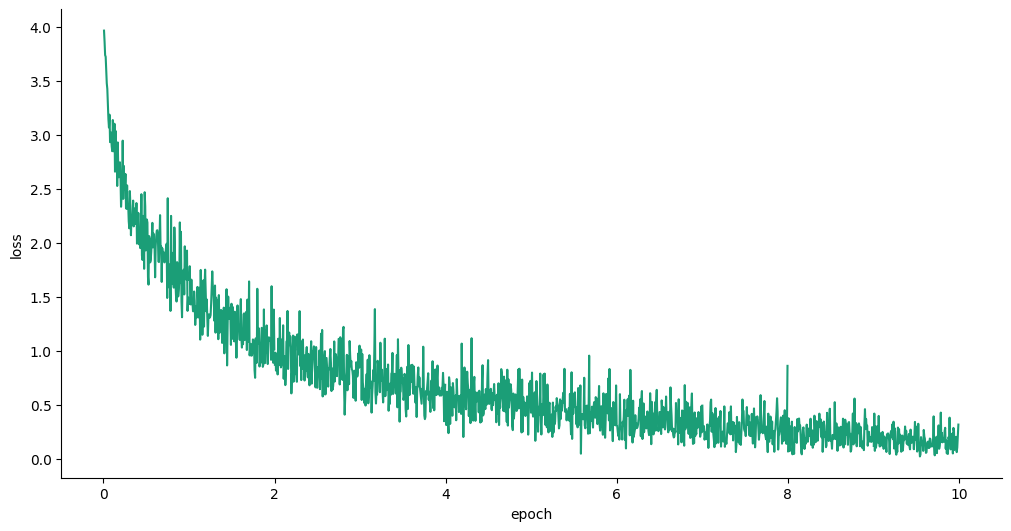

In [33]:
# @title epoch vs loss

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_logs.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

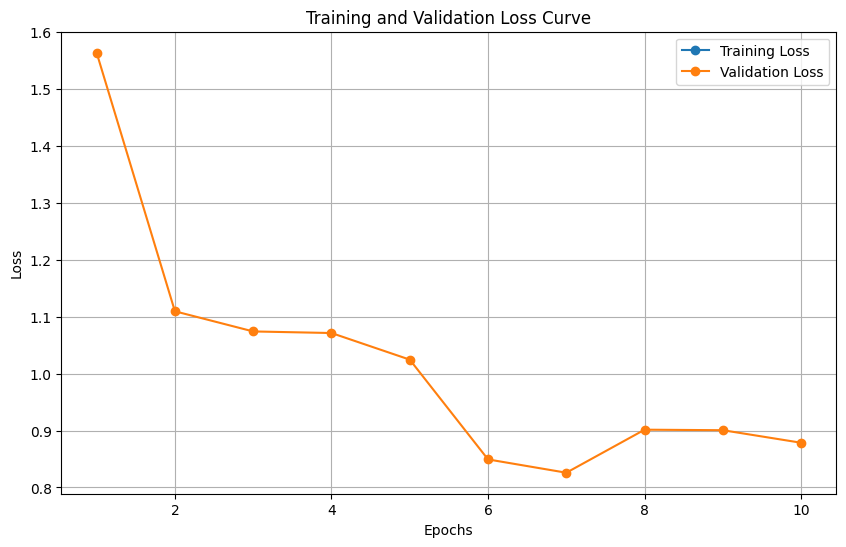

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df_logs['epoch'], df_logs['loss'], label="Training Loss", marker='o')
plt.plot(df_logs['epoch'], df_logs['eval_loss'], label="Validation Loss", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


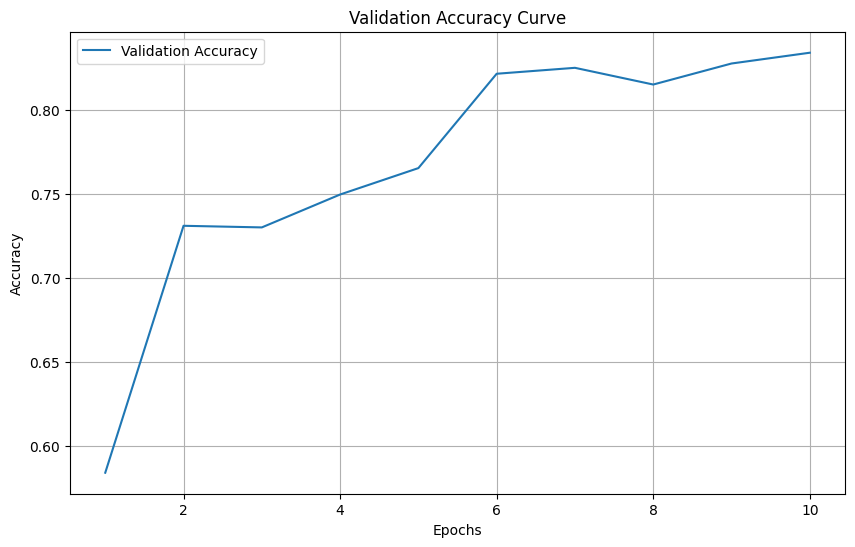

In [37]:
# Accuracy may be missing from some rows where it wasn't calculated (like during training steps)
# Filter out rows where accuracy isn't recorded
df_logs = df_logs.dropna(subset=['eval_accuracy'])

plt.figure(figsize=(10, 6))
plt.plot(df_logs['epoch'], df_logs['eval_accuracy'], label="Validation Accuracy", marker = "o")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()
